<a href="https://colab.research.google.com/github/bhkpriyanka/EIP4/blob/master/Session5/LRFinder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

http://teleported.in/posts/cyclic-learning-rate/   
https://github.com/titu1994/keras-one-cycle/blob/master/clr.py

In [0]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')
!unzip -q "/content/gdrive/My Drive/EIP4/Session5/hvc_data.zip"
# look for `hvc_annotations.csv` file and `resized` dir
%ls 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
gdrive/  hvc_annotations.csv  resized/  sample_data/


In [0]:
import cv2
import json

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from matplotlib import pyplot as plt
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.layers.pooling import GlobalAveragePooling2D
from keras.regularizers import l2
from keras.applications import VGG16
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model, Sequential
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [0]:
batch_size = 32
#nb_classes = 10
nb_epoch = 1  # Only finding lr
data_augmentation = True

In [0]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


In [0]:
one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

one_hot_df.head().T

,0,1,2,3,4
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg
gender_female,0,1,0,0,1
gender_male,1,0,1,1,0
imagequality_Average,1,1,0,0,0
imagequality_Bad,0,0,0,0,0
imagequality_Good,0,0,1,1,1
age_15-25,0,0,0,0,0
age_25-35,0,0,0,0,0
age_35-45,1,1,0,0,1
age_45-55,0,0,1,1,0


In [0]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.15, random_state =1)
train_df.shape, val_df.shape
num_samples=train_df.shape[0]


In [0]:
import keras
import numpy as np

# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""

    
    def __init__(self, df, batch_size=32, shuffle=True, augmentation =None, subtract_pixel_mean=False):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.augmentation = augmentation
        self.subtract_pixel_mean = subtract_pixel_mean

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        image = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])
        
        # If subtract pixel mean is enabled
        '''if self.subtract_pixel_mean:
          mean = []
          std  = []
          for i in range(image.shape[-1]):
            pixels = image[:, :, :, i].ravel()
            mean.append(np.mean(pixels))
            std.append(np.std(pixels))'''

        if self.augmentation is not None:
                 image = self.augmentation.flow(image,shuffle = False).next()

        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
        return image, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


In [0]:
train_gen = PersonDataGenerator(train_df, batch_size=32,subtract_pixel_mean=False,
                            augmentation = ImageDataGenerator(horizontal_flip = True,rotation_range = 20, zoom_range = 0.2 ))
                                                          
valid_gen = PersonDataGenerator(val_df, batch_size=32, shuffle=False, subtract_pixel_mean=False)

In [0]:
n = 2
version = 1

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 5 + 2
    

In [0]:

def resnet_layer(inputs,
                 num_filters=32,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [0]:
def resnet_v1(input_shape, depth):
       
    if (depth - 2) % 5!= 0:
        raise ValueError('depth should be 4n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 32
    num_res_blocks = int((depth - 2) / 5)

    inputs = Input(shape=input_shape)
    
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(5):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    output = AveragePooling2D(pool_size=2)(x)
    #y = Flatten()(x)
    '''outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)'''

    # Instantiate model.
    model = Model(inputs=inputs, outputs=output)
    return model

In [0]:
# get number of output units from data
images, targets = next(iter(train_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'age': 5,
 'bag': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}

In [0]:
backbone = resnet_v1(input_shape= (224,224,3), depth=depth)

neck = backbone.output
neck = GlobalAveragePooling2D()(neck)
#neck = Flatten(name="flatten")(neck)
#neck = Dense(512, activation="relu")(neck)


def build_tower(in_layer):
    neck = Dropout(0.1)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    #neck = Dropout(0.3)(in_layer)
    #neck = Dense(128, activation="relu")(neck)
    return neck


def build_head(name, in_layer):
    return Dense(
        num_units[name], activation="softmax", name=f"{name}_output"
    )(in_layer)

# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(neck))


model = Model(
    inputs=backbone.input, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)
opt = SGD(lr=0.001, momentum=0.9)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model.summary()













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 224, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 224, 224, 32) 0       

In [0]:
from keras.callbacks import Callback
from keras import backend as K
import warnings
class LRFinder(Callback):
    def __init__(self,
                 num_samples,
                 batch_size,
                 minimum_lr=1e-5,
                 maximum_lr=10.,
                 lr_scale='exp',
                 validation_data=None,
                 validation_sample_rate=5,
                 stopping_criterion_factor=4.,
                 loss_smoothing_beta=0.98,
                 save_dir=None,
                 verbose=True):
        """
        This class uses the Cyclic Learning Rate history to find a
        set of learning rates that can be good initializations for the
        One-Cycle training proposed by Leslie Smith in the paper referenced
        below.
        A port of the Fast.ai implementation for Keras.
        # Note
        This requires that the model be trained for exactly 1 epoch. If the model
        is trained for more epochs, then the metric calculations are only done for
        the first epoch.
        # Interpretation
        Upon visualizing the loss plot, check where the loss starts to increase
        rapidly. Choose a learning rate at somewhat prior to the corresponding
        position in the plot for faster convergence. This will be the maximum_lr lr.
        Choose the max value as this value when passing the `max_val` argument
        to OneCycleLR callback.
        Since the plot is in log-scale, you need to compute 10 ^ (-k) of the x-axis
        # Arguments:
            num_samples: Integer. Number of samples in the dataset.
            batch_size: Integer. Batch size during training.
            minimum_lr: Float. Initial learning rate (and the minimum).
            maximum_lr: Float. Final learning rate (and the maximum).
            lr_scale: Can be one of ['exp', 'linear']. Chooses the type of
                scaling for each update to the learning rate during subsequent
                batches. Choose 'exp' for large range and 'linear' for small range.
            validation_data: Requires the validation dataset as a tuple of
                (X, y) belonging to the validation set. If provided, will use the
                validation set to compute the loss metrics. Else uses the training
                batch loss. Will warn if not provided to alert the user.
            validation_sample_rate: Positive or Negative Integer. Number of batches to sample from the
                validation set per iteration of the LRFinder. Larger number of
                samples will reduce the variance but will take longer time to execute
                per batch.
                If Positive > 0, will sample from the validation dataset
                If Megative, will use the entire dataset
            stopping_criterion_factor: Integer or None. A factor which is used
                to measure large increase in the loss value during training.
                Since callbacks cannot stop training of a model, it will simply
                stop logging the additional values from the epochs after this
                stopping criterion has been met.
                If None, this check will not be performed.
            loss_smoothing_beta: Float. The smoothing factor for the moving
                average of the loss function.
            save_dir: Optional, String. If passed a directory path, the callback
                will save the running loss and learning rates to two separate numpy
                arrays inside this directory. If the directory in this path does not
                exist, they will be created.
            verbose: Whether to print the learning rate after every batch of training.
        # References:
            - [A disciplined approach to neural network hyper-parameters: Part 1 -- learning rate, batch size, weight_decay, and weight decay](https://arxiv.org/abs/1803.09820)
        """
        super(LRFinder, self).__init__()

        if lr_scale not in ['exp', 'linear']:
            raise ValueError("`lr_scale` must be one of ['exp', 'linear']")

        if validation_data is not None:
            self.validation_data = validation_data
            self.use_validation_set = True

            if validation_sample_rate > 0 or validation_sample_rate < 0:
                self.validation_sample_rate = validation_sample_rate
            else:
                raise ValueError("`validation_sample_rate` must be a positive or negative integer other than o")
        else:
            self.use_validation_set = False
            self.validation_sample_rate = 0

        self.num_samples = num_samples
        self.batch_size = batch_size
        self.initial_lr = minimum_lr
        self.final_lr = maximum_lr
        self.lr_scale = lr_scale
        self.stopping_criterion_factor = stopping_criterion_factor
        self.loss_smoothing_beta = loss_smoothing_beta
        self.save_dir = save_dir
        self.verbose = verbose

        self.num_batches_ = num_samples // batch_size
        self.current_lr_ = minimum_lr

        if lr_scale == 'exp':
            self.lr_multiplier_ = (maximum_lr / float(minimum_lr)) ** (
                1. / float(self.num_batches_))
        else:
            extra_batch = int((num_samples % batch_size) != 0)
            self.lr_multiplier_ = np.linspace(
                minimum_lr, maximum_lr, num=self.num_batches_ + extra_batch)

        # If negative, use entire validation set
        if self.validation_sample_rate < 0:
            self.validation_sample_rate = self.validation_data[0].shape[0] // batch_size

        self.current_batch_ = 0
        self.current_epoch_ = 0
        self.best_loss_ = 1e6
        self.running_loss_ = 0.

        self.history = {}

    def on_train_begin(self, logs=None):

        self.current_epoch_ = 1
        K.set_value(self.model.optimizer.lr, self.initial_lr)

        warnings.simplefilter("ignore")

    def on_epoch_begin(self, epoch, logs=None):
        self.current_batch_ = 0

        if self.current_epoch_ > 1:
            warnings.warn(
                "\n\nLearning rate finder should be used only with a single epoch. "
                "Hereafter, the callback will not measure the losses.\n\n")

    def on_batch_begin(self, batch, logs=None):
        self.current_batch_ += 1

    def on_batch_end(self, batch, logs=None):
        if self.current_epoch_ > 1:
            return

        if self.use_validation_set:
            X, Y = self.validation_data[0], self.validation_data[1]

            # use 5 random batches from test set for fast approximate of loss
            num_samples = self.batch_size * self.validation_sample_rate

            if num_samples > X.shape[0]:
                num_samples = X.shape[0]

            idx = np.random.choice(X.shape[0], num_samples, replace=False)
            x = X[idx]
            y = Y[idx]

            values = self.model.evaluate(x, y, batch_size=self.batch_size, verbose=False)
            loss = values[0]
        else:
            loss = logs['loss']

        # smooth the loss value and bias correct
        running_loss = self.loss_smoothing_beta * loss + (
            1. - self.loss_smoothing_beta) * loss
        running_loss = running_loss / (
            1. - self.loss_smoothing_beta**self.current_batch_)

        # stop logging if loss is too large
        if self.current_batch_ > 1 and self.stopping_criterion_factor is not None and (
                running_loss >
                self.stopping_criterion_factor * self.best_loss_):

            if self.verbose:
                print(" - LRFinder: Skipping iteration since loss is %d times as large as best loss (%0.4f)"
                      % (self.stopping_criterion_factor, self.best_loss_))
            return

        if running_loss < self.best_loss_ or self.current_batch_ == 1:
            self.best_loss_ = running_loss

        current_lr = K.get_value(self.model.optimizer.lr)

        self.history.setdefault('running_loss_', []).append(running_loss)
        if self.lr_scale == 'exp':
            self.history.setdefault('log_lrs', []).append(np.log10(current_lr))
        else:
            self.history.setdefault('log_lrs', []).append(current_lr)

        # compute the lr for the next batch and update the optimizer lr
        if self.lr_scale == 'exp':
            current_lr *= self.lr_multiplier_
        else:
            current_lr = self.lr_multiplier_[self.current_batch_ - 1]

        K.set_value(self.model.optimizer.lr, current_lr)

        # save the other metrics as well
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        if self.verbose:
            if self.use_validation_set:
                print(" - LRFinder: val_loss: %1.4f - lr = %1.8f " %
                      (values[0], current_lr))
            else:
                print(" - LRFinder: lr = %1.8f " % current_lr)

    def on_epoch_end(self, epoch, logs=None):
        if self.save_dir is not None and self.current_epoch_ <= 1:
            if not os.path.exists(self.save_dir):
                os.makedirs(self.save_dir)

            losses_path = os.path.join(self.save_dir, 'losses.npy')
            lrs_path = os.path.join(self.save_dir, 'lrs.npy')

            np.save(losses_path, self.losses)
            np.save(lrs_path, self.lrs)

            if self.verbose:
                print("\tLR Finder : Saved the losses and learning rate values in path : {%s}"
                      % (self.save_dir))

        self.current_epoch_ += 1

        warnings.simplefilter("default")

    def plot_schedule(self, clip_beginning=None, clip_endding=None):
        """
        Plots the schedule from the callback itself.
        # Arguments:
            clip_beginning: Integer or None. If positive integer, it will
                remove the specified portion of the loss graph to remove the large
                loss values in the beginning of the graph.
            clip_endding: Integer or None. If negative integer, it will
                remove the specified portion of the ending of the loss graph to
                remove the sharp increase in the loss values at high learning rates.
        """
        try:
            import matplotlib.pyplot as plt
            plt.style.use('seaborn-white')
        except ImportError:
            print(
                "Matplotlib not found. Please use `pip install matplotlib` first."
            )
            return

        if clip_beginning is not None and clip_beginning < 0:
            clip_beginning = -clip_beginning

        if clip_endding is not None and clip_endding > 0:
            clip_endding = -clip_endding

        losses = self.losses
        lrs = self.lrs

        if clip_beginning:
            losses = losses[clip_beginning:]
            lrs = lrs[clip_beginning:]

        if clip_endding:
            losses = losses[:clip_endding]
            lrs = lrs[:clip_endding]

        plt.plot(lrs, losses)
        plt.title('Learning rate vs Loss')
        plt.xlabel('learning rate')
        plt.ylabel('loss')
        plt.show()

    @classmethod
    def restore_schedule_from_dir(cls,
                                  directory,
                                  clip_beginning=None,
                                  clip_endding=None):
        """
        Loads the training history from the saved numpy files in the given directory.
        # Arguments:
            directory: String. Path to the directory where the serialized numpy
                arrays of the loss and learning rates are saved.
            clip_beginning: Integer or None. If positive integer, it will
                remove the specified portion of the loss graph to remove the large
                loss values in the beginning of the graph.
            clip_endding: Integer or None. If negative integer, it will
                remove the specified portion of the ending of the loss graph to
                remove the sharp increase in the loss values at high learning rates.
        Returns:
            tuple of (losses, learning rates)
        """
        if clip_beginning is not None and clip_beginning < 0:
            clip_beginning = -clip_beginning

        if clip_endding is not None and clip_endding > 0:
            clip_endding = -clip_endding

        losses_path = os.path.join(directory, 'losses.npy')
        lrs_path = os.path.join(directory, 'lrs.npy')

        if not os.path.exists(losses_path) or not os.path.exists(lrs_path):
            print("%s and %s could not be found at directory : {%s}" %
                  (losses_path, lrs_path, directory))

            losses = None
            lrs = None

        else:
            losses = np.load(losses_path)
            lrs = np.load(lrs_path)

            if clip_beginning:
                losses = losses[clip_beginning:]
                lrs = lrs[clip_beginning:]

            if clip_endding:
                losses = losses[:clip_endding]
                lrs = lrs[:clip_endding]

        return losses, lrs

    @classmethod
    def plot_schedule_from_file(cls,
                                directory,
                                clip_beginning=None,
                                clip_endding=None):
        """
        Plots the schedule from the saved numpy arrays of the loss and learning
        rate values in the specified directory.
        # Arguments:
            directory: String. Path to the directory where the serialized numpy
                arrays of the loss and learning rates are saved.
            clip_beginning: Integer or None. If positive integer, it will
                remove the specified portion of the loss graph to remove the large
                loss values in the beginning of the graph.
            clip_endding: Integer or None. If negative integer, it will
                remove the specified portion of the ending of the loss graph to
                remove the sharp increase in the loss values at high learning rates.
        """
        try:
            import matplotlib.pyplot as plt
            plt.style.use('seaborn-white')
        except ImportError:
            print("Matplotlib not found. Please use `pip install matplotlib` first.")
            return

        losses, lrs = cls.restore_schedule_from_dir(
            directory,
            clip_beginning=clip_beginning,
            clip_endding=clip_endding)

        if losses is None or lrs is None:
            return
        else:
            plt.plot(lrs, losses)
            plt.title('Learning rate vs Loss')
            plt.xlabel('learning rate')
            plt.ylabel('loss')
            plt.show()

    @property
    def lrs(self):
        return np.array(self.history['log_lrs'])

    @property
    def losses(self):
        return np.array(self.history['running_loss_'])

In [0]:
lr_finder = LRFinder(num_samples, batch_size, minimum_lr=1e-3, maximum_lr=10.,
                     lr_scale='exp',
                     # validation_data=(X_test, Y_test),  # use the validation data for losses
                     validation_sample_rate=5,
                     #save_dir='weights/', 
                     verbose=True)

In [0]:
# Ensure that number of epochs = 1 when calling fit()
# Fit the model on the batches generated by datagen.flow().
    model.fit_generator(generator=train_gen,
                        steps_per_epoch= num_samples // batch_size,
                        validation_data=valid_gen,
                        epochs=nb_epoch, verbose=1,
                        callbacks=[lr_finder])

Epoch 1/1
359/360 [============================>.] - ETA: 43s - loss: nan - gender_output_loss: nan - image_quality_output_loss: nan - age_output_loss: nan - weight_output_loss: nan - bag_output_loss: nan - footwear_output_loss: nan - pose_output_loss: nan - emotion_output_loss: nan - gender_output_acc: 0.4843 - image_quality_output_acc: 0.5420 - age_output_acc: 0.2597 - weight_output_acc: 0.6218 - bag_output_acc: 0.4251 - footwear_output_acc: 0.4079 - pose_output_acc: 0.3658 - emotion_output_acc: 0.3703  - LRFinder: lr = 9.50117655 
 - LRFinder: lr = 9.74739380 
360/360 [==============================] - 16403s 46s/step - loss: nan - gender_output_loss: nan - image_quality_output_loss: nan - age_output_loss: nan - weight_output_loss: nan - bag_output_loss: nan - footwear_output_loss: nan - pose_output_loss: nan - emotion_output_loss: nan - gender_output_acc: 0.4840 - image_quality_output_acc: 0.5422 - age_output_acc: 0.2597 - weight_output_acc: 0.6217 - bag_output_acc: 0.4250 - footwe

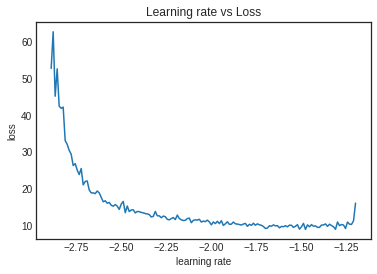

In [0]:
lr_finder.plot_schedule(clip_beginning=10, clip_endding=5)

#scores = model.evaluate(X_test, Y_test, batch_size=batch_size)
#for score, metric_name in zip(scores, model.metrics_names):
    #print("%s : %0.4f" % (metric_name, score))

In [0]:
# Ensure that number of epochs = 1 when calling fit()
#model.fit(X, Y, epochs=1, batch_size=batch_size, callbacks=[clr_triangular])